<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/main/tutorials/W1D3_MultiLayerPerceptrons/W1D3_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W1D3_MultiLayerPerceptrons/W1D3_Tutorial1.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 1: Biological vs. Artificial Neural Networks

**Week 1, Day 3: Multi Layer Perceptrons**

**By Neuromatch Academy**

__Content creators:__ Arash Ash, Surya Ganguli

__Content reviewers:__ Saeed Salehi, Felix Bartsch, Yu-Fang Yang, Antoine De Comite, Melvin Selim Atay, Kelson Shilling-Scrivo

__Content editors:__ Gagana B, Kelson Shilling-Scrivo, Spiros Chavlis

__Production editors:__ Anoop Kulkarni, Kelson Shilling-Scrivo, Gagana B, Spiros Chavlis

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial objectives

In this tutorial, we will explore the Multi-layer Perceptrons (MLPs). MLPs are arguably one of the most tractable models (due to their flexibility) that we can use to study deep learning fundamentals. Here we will learn why they are: 

* Similar to biological networks
* Good at function approximation
* Implemented the way they are in PyTorch

In [1]:
# @title Tutorial slides

from IPython.display import IFrame
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/4ye56/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

These are the slides for all videos in the tutorial. If you want to locally download the slides, click [here](https://osf.io/4ye56/download).

---
# Setup

This is a GPU free notebook!

In [2]:
# @title Install dependencies
!pip install git+https://github.com/NeuromatchAcademy/evaltools --quiet
from evaltools.airtable import AirtableForm

# Generate airtable form
atform = AirtableForm('appn7VdPRseSoMXEG','W1D3_T1','https://portal.neuromatchacademy.org/api/redirect/to/9c55f6cb-cdf9-4429-ac1c-ec44fe64c303')

In [3]:
# Imports
import random

import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from IPython.display import display
from torch.utils.data import DataLoader, TensorDataset

In [4]:
# @title Figure settings
import ipywidgets as widgets       # Interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [5]:
# @title Plotting functions

def imshow(img):
  """
  Helper function to plot unnormalised image

  Args:
    img: torch.tensor
      Image to be displayed

  Returns:
    Nothing
  """
  img = img / 2 + 0.5     # Unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.axis(False)
  plt.show()


def plot_function_approximation(x, relu_acts, y_hat):
  """
  Helper function to plot ReLU activations and
  function approximations

  Args:
    x: torch.tensor
      Incoming Data
    relu_acts: torch.tensor
      Computed ReLU activations for each point along the x axis (x)
    y_hat: torch.tensor
      Estimated labels/class predictions
      Weighted sum of ReLU activations for every point along x axis

  Returns:
    Nothing
  """
  fig, axes = plt.subplots(2, 1)

  # Plot ReLU Activations
  axes[0].plot(x, relu_acts.T);
  axes[0].set(xlabel='x',
              ylabel='Activation',
              title='ReLU Activations - Basis Functions')
  labels = [f"ReLU {i + 1}" for i in range(relu_acts.shape[0])]
  axes[0].legend(labels, ncol = 2)

  # Plot Function Approximation
  axes[1].plot(x, torch.sin(x), label='truth')
  axes[1].plot(x, y_hat, label='estimated')
  axes[1].legend()
  axes[1].set(xlabel='x',
              ylabel='y(x)',
              title='Function Approximation')

  plt.tight_layout()
  plt.show()

In [6]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [7]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.
# NOTE: This is mostly a GPU free tutorial.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [8]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook. 
If you want to disable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `None` from the dropdown menu


---
# Section 0: Introduction to MLPs

In [9]:
# @title Video 0: Introduction
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1E3411r7TL", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"Gh0KYl7ViAc", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

#add event to airtable
atform.add_event('Video 0: Introduction')

display(out)

---
# Section 1: The Need for MLPs

*Time estimate: ~35 mins*

In [10]:
# @title Video 1: Universal Approximation Theorem
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1SP4y147Uv", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"tg8HHKo1aH4", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 1: Universal Approximation Theorem')

display(out)

## Coding Exercise 1: Function approximation with ReLU
Through the Universal Approximation Algorithm, we learned that one hidden layer MLPs are enough to approximate any smooth function! Now let's manually fit a sine function using ReLU activation. 

We will approximate the sine function using a linear combination (a weighted sum) of ReLUs with slope 1. We need to determine the bias terms (which determines where the ReLU inflection point from 0 to linear occurs) and how to weight each ReLU. The idea is to set the weights iteratively so that the slope changes in the new sample's direction.

First, we generate our "training data" from a sine function using `torch.sine` function.

```python
>>> import torch
>>> torch.manual_seed(2021)
<torch._C.Generator object at 0x7f8734c83830>
>>> a = torch.randn(5)
>>> print(a)
tensor([ 2.2871,  0.6413, -0.8615, -0.3649, -0.6931])
>>> torch.sin(a)
tensor([ 0.7542,  0.5983, -0.7588, -0.3569, -0.6389])
```

These are the points we will use to learn how to approximate the function. We have 10 training data points so we will have 9 ReLUs (we don't need a ReLU for the last data point as we don't have anything to the right of it to model). 

We first need to figure out the bias term for each ReLU and compute the activation of each ReLU where:

\begin{equation}
  y(x) = \text{max}(0, x+b)
\end{equation}

We then need to figure out the correct weights on each ReLU so the linear combination approximates the desired function.

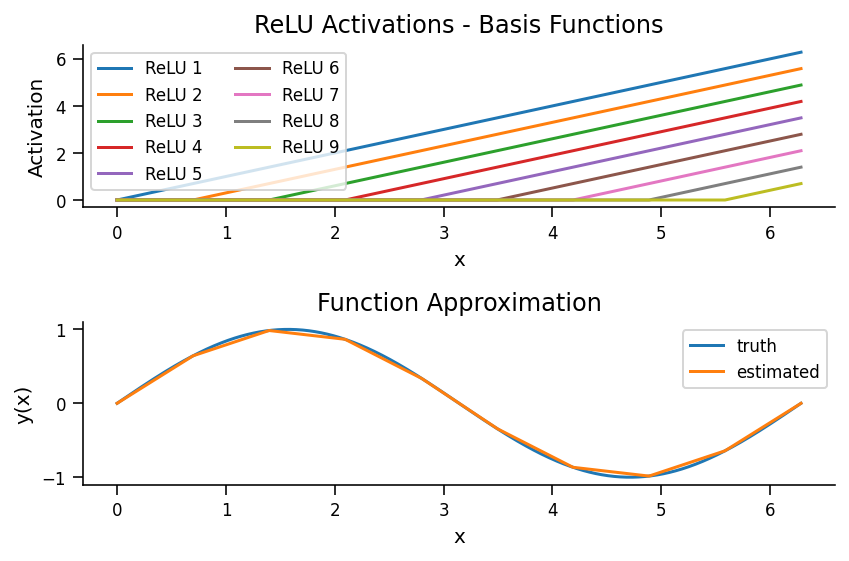

In [11]:
def approximate_function(x_train, y_train):
  """
  Function to compute and combine ReLU activations

  Args:
    x_train: torch.tensor
      Training data
    y_train: torch.tensor
      Ground truth labels corresponding to training data

  Returns:
    relu_acts: torch.tensor
      Computed ReLU activations for each point along the x axis (x)
    y_hat: torch.tensor
      Estimated labels/class predictions
      Weighted sum of ReLU activations for every point along x axis
    x: torch.tensor
      x-axis points
  """
  ####################################################################
  # TODO Fill in missing code below (...),
  # then remove or comment the line below to test your function
  #raise NotImplementedError("Complete approximate_function!")
  ####################################################################

  # Number of relus
  n_relus = x_train.shape[0] - 1

  # x axis points (more than x train)
  x = torch.linspace(torch.min(x_train), torch.max(x_train), 1000)

  ## COMPUTE RELU ACTIVATIONS
  
  # First determine what bias terms should be for each of `n_relus` ReLUs
  b = -x_train[:-1]

  # Compute ReLU activations for each point along the x axis (x)
  relu_acts = torch.zeros((n_relus, x.shape[0]))

  for i_relu in range(n_relus):
    relu_acts[i_relu, :] = torch.relu(x + b[i_relu])

  ## COMBINE RELU ACTIVATIONS

  # Set up weights for weighted sum of ReLUs
  combination_weights = torch.zeros((n_relus, ))

  # Figure out weights on each ReLU
  prev_slope = 0
  for i in range(n_relus):
    delta_x = x_train[i+1] - x_train[i]
    slope = (y_train[i+1] - y_train[i]) / delta_x
    combination_weights[i] = slope - prev_slope
    prev_slope = slope

  # Get output of weighted sum of ReLU activations for every point along x axis
  y_hat = combination_weights @ relu_acts

  return y_hat, relu_acts, x

# Add event to airtable
#atform.add_event('Coding Exercise 1: Function approximation with ReLU')


# Make training data from sine function
N_train = 10
x_train = torch.linspace(0, 2*np.pi, N_train).view(-1, 1)
y_train = torch.sin(x_train)

## Uncomment the lines below to test your function approximation
y_hat, relu_acts, x = approximate_function(x_train, y_train)
plot_function_approximation(x, relu_acts, y_hat)

As you see in the top panel, we obtain 10 shifted ReLUs with the same slope. These are the basis functions that MLP uses to span the functional space, i.e., MLP finds a linear combination of these ReLUs.

---
# Section 2: MLPs in Pytorch

*Time estimate: ~1hr and 20 mins*

In [12]:
# @title Video 2: Building MLPs in PyTorch
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1zh411z7LY", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"XtwLnaYJ7uc", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 2: Building MLPs in PyTorch')

display(out)

In the previous segment, we implemented a function to approximate any smooth function using MLPs. We saw that using Lipschitz continuity; We can prove that our approximation is mathematically correct. MLPs are fascinating, but before we get into the details on designing them, let's familiarize ourselves with some basic terminology of MLPs - layer, neuron, depth, width, weight, bias, and activation function. Armed with these ideas, we can now design an MLP given its input, hidden layers, and output size.

## Coding Exercise 2: Implement a general-purpose MLP in Pytorch
The objective is to design an MLP with these properties:
* Works with any input (1D, 2D, etc.)
* Construct any number of given hidden layers using `nn.Sequential()` and `add_module()` function
* Use the same given activation function (i.e., [Leaky ReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html)) in all hidden layers

**Leaky ReLU** is described by the following mathematical formula:

\begin{align}
\text{LeakyReLU}(x) &= \text{max}(0,x) + \text{negative_slope} \cdot \text{min}(0, x) \\
&=
\left\{
  \begin{array}{ll}
  x & ,\; \text{if} \; x \ge 0 \\
  \text{negative_slope} \cdot x & ,\;  \text{otherwise}
  \end{array}
\right.
\end{align}

In [13]:
class Net(nn.Module):
  """
  Initialize MLP Network
  """

  def __init__(self, actv, input_feature_num, hidden_unit_nums, output_feature_num):
    """
    Initialize MLP Network parameters

    Args:
      actv: string
        Activation function
      input_feature_num: int
        Number of input features
      hidden_unit_nums: list
        Number of units in the hidden layer
      output_feature_num: int
        Number of output features

    Returns:
      Nothing
    """
    super(Net, self).__init__()
    self.input_feature_num = input_feature_num # Save the input size for reshaping later
    self.mlp = nn.Sequential() # Initialize layers of MLP

    in_num = input_feature_num # Initialize the temporary input feature to each layer
    for i in range(len(hidden_unit_nums)): # Loop over layers and create each one

      ####################################################################
      # Fill in missing code below (...),
      # Then remove or comment the line below to test your function
      ####################################################################

      out_num = hidden_unit_nums[i] # Assign the current layer hidden unit from list
      layer = nn.Linear(in_num, out_num) # Use nn.Linear to define the layer
      in_num = out_num # Assign next layer input using current layer output
      self.mlp.add_module('Linear_%d'%i, layer) # Append layer to the model with a name

      actv_layer = eval('nn.%s'%actv) # Assign activation function (eval allows us to instantiate object from string)
      self.mlp.add_module('Activation_%d'%i, actv_layer) # Append activation to the model with a name

    out_layer = nn.Linear(in_num, output_feature_num) # Create final layer
    self.mlp.add_module('Output_Linear', out_layer) # Append the final layer

  def forward(self, x):
    """
    Simulate forward pass of MLP Network

    Args:
      x: torch.tensor
        Input data

    Returns:
      logits: Instance of MLP
        Forward pass of MLP
    """
    # Reshape inputs to (batch_size, input_feature_num)
    # Just in case the input vector is not 2D, like an image!
    x = x.view(-1, self.input_feature_num)

    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    ####################################################################

    logits = self.mlp(x) # Forward pass of MLP
    return logits

# Add event to airtable
atform.add_event('Coding Exercise 2: Implement a general-purpose MLP in Pytorch')


input = torch.zeros((100, 2))
## Uncomment below to create network and test it on input
net = Net(actv='LeakyReLU(0.1)', input_feature_num=2, hidden_unit_nums=[100, 10, 5], output_feature_num=1).to(DEVICE)
y = net(input.to(DEVICE))
print(f'The output shape is {y.shape} for an input of shape {input.shape}')

The output shape is torch.Size([100, 1]) for an input of shape torch.Size([100, 2])


```
The output shape is torch.Size([100, 1]) for an input of shape torch.Size([100, 2])
```

## Section 2.1: Classification with MLPs

In [14]:
# @title Video 3: Cross Entropy
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1Ag41177mB", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"N8pVCbTlves", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 3: Cross Entropy')

display(out)

The main loss function we could use out of the box for multi-class classification for `N` samples and `C` number of classes is:
* **CrossEntropyLoss**:
This criterion expects a batch of predictions `x` with shape `(N, C)` and class index in the range $[0, C-1]$ as the target (label) for each `N` samples, hence a batch of `labels` with shape `(N, )`. There are other optional parameters like class weights and class ignores. Feel free to check the PyTorch documentation [here](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) for more detail. Additionally, [here](https://sparrow.dev/cross-entropy-loss-in-pytorch/) you can learn where is appropriate to use the CrossEntropyLoss.

To get CrossEntropyLoss of a sample $i$, we could first calculate $-\log(\text{softmax(x}))$ and then take the element corresponding to $\text { labels }_i$ as the loss. However, due to numerical stability, we implement this more stable equivalent form,

\begin{equation}
\operatorname{loss}(x_i, \text { labels }_i)=-\log \left(\frac{\exp (x[\text { labels }_i])}{\sum_{j} \exp (x[j])}\right)=-x_i[\text { labels }_i]+\log \left(\sum_{j=1}^C \exp (x_i[j])\right)
\end{equation}

### Coding Exercise 2.1: Implement Batch Cross Entropy Loss

To recap, since we will be doing batch learning, we'd like a loss function that given:
* A batch of predictions `x` with shape `(N, C)` 
* A batch of `labels` with shape `(N, )` that ranges from `0` to `C-1`

Returns the average loss $L$ calculated according to:

\begin{align}
loss(x_i, \text { labels }_i) &= -x_i[\text { labels }_i]+\log \left(\sum_{j=1}^C \exp (x_i[j])\right) \\
L &= \frac{1}{N} \sum_{i=1}^{N}{loss(x_i, \text { labels }_i)}
\end{align}

Steps:

1.   Use indexing operation to get predictions of class corresponding to the labels (i.e., $x_i[\text { labels }_i]$)
2.   Compute $loss(x_i, \text { labels }_i)$ vector (`losses`) using `torch.log()` and `torch.exp()` without Loops!
3. Return the average of the loss vector

In [15]:
def cross_entropy_loss(x, labels):
  """
  Helper function to compute cross entropy loss

  Args:
    x: torch.tensor
      Model predictions we'd like to evaluate using labels
    labels: torch.tensor
      Ground truth

  Returns:
    avg_loss: float
      Average of the loss vector
  """
  x_of_labels = torch.zeros(len(labels))
  ####################################################################
  # Fill in missing code below (...),
  # then remove or comment the line below to test your function
  ####################################################################
  # 1. Prediction for each class corresponding to the label
  for i, label in enumerate(labels):
    x_of_labels[i] = x[i, label]
  # 2. Loss vector for the batch
  losses = -x_of_labels+torch.log(torch.sum(torch.exp(x), axis=1))
  # 3. Return the average of the loss vector
  avg_loss = losses.mean()

  return avg_loss

# Add event to airtable
#atform.add_event('Coding Exercise 2.1: Implement Batch Cross Entropy Loss')


labels = torch.tensor([0, 1]) # labels is not one-hot coding!
x = torch.tensor([[10.0, 1.0, -1.0, -20.0],  # Correctly classified because value of index 0 is biggest.
                  [10.0, 10.0, 2.0, -10.0]])  # Not correctly classified because value of index 1 is not biggest.
CE = nn.CrossEntropyLoss()
pytorch_loss = CE(x, labels).item()
## Uncomment below to test your function
our_loss = cross_entropy_loss(x, labels).item()
print(f'Our CE loss: {our_loss:0.8f}, Pytorch CE loss: {pytorch_loss:0.8f}')
print(f'Difference: {np.abs(our_loss - pytorch_loss):0.8f}')

Our CE loss: 0.34672737, Pytorch CE loss: 0.34672749
Difference: 0.00000012


```
Our CE loss: 0.34672737, Pytorch CE loss: 0.34672749
Difference: 0.00000012
```

## Section 2.2: Spiral Classification Dataset
Before we could start optimizing these loss functions, we need a dataset!

Let's turn this fancy-looking equation into a classification dataset

\begin{equation}
\begin{array}{c}
X_{k}(t)=t\left(\begin{array}{c}
\sin \left[\frac{2 \pi}{K}\left(2 t+k-1\right)\right]+\mathcal{N}\left(0, \sigma\right) \\
\cos \left[\frac{2 \pi}{K}\left(2 t+k-1\right)\right]+\mathcal{N}\left(0, \sigma\right) 
\end{array}\right)
\end{array}, \quad 0 \leq t \leq 1, \quad k=1, \ldots, K
\end{equation}

Random seed 2021 has been set.


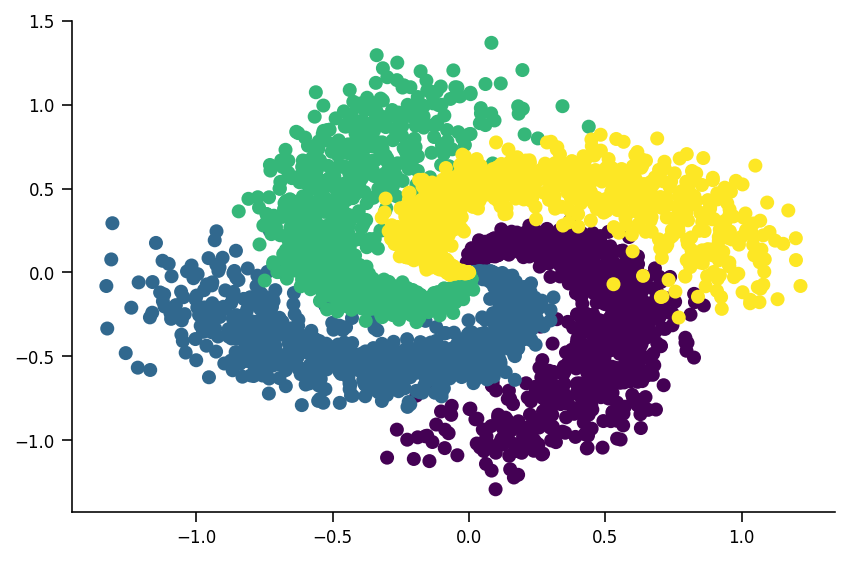

In [16]:
def create_spiral_dataset(K, sigma, N):
  """
  Function to simulate spiral dataset

  Args:
    K: int
      Number of classes
    sigma: float
      Standard deviation
    N: int
      Number of data points

  Returns:
    X: torch.tensor
      Spiral data
    y: torch.tensor
      Corresponding ground truth
  """

  # Initialize t, X, y
  t = torch.linspace(0, 1, N)
  X = torch.zeros(K*N, 2)
  y = torch.zeros(K*N)

  # Create data
  for k in range(K):
    X[k*N:(k+1)*N, 0] = t*(torch.sin(2*np.pi/K*(2*t+k)) + sigma*torch.randn(N))
    X[k*N:(k+1)*N, 1] = t*(torch.cos(2*np.pi/K*(2*t+k)) + sigma*torch.randn(N))
    y[k*N:(k+1)*N] = k

  return X, y


# Set parameters
K = 4
sigma = 0.16
N = 1000

set_seed(seed=SEED)
X, y = create_spiral_dataset(K, sigma, N)
plt.scatter(X[:, 0], X[:, 1], c = y)
plt.show()

## Section 2.3: Training and Evaluation

In [17]:
# @title Video 4: Training and Evaluating an MLP
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1QV411p7mF", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"DfXZhRfBEqQ", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 4: Training and Evaluating an MLP')

display(out)

### Coding Exercise 2.3: Implement it for a classfication task
Now that we have the spiral dataset and a loss function, it's your turn to implement a simple train/test split for training and validation.

Steps to follow: 
  * Dataset shuffle
  * Train/Test split (20% for test)
  * Dataloader definition
  * Training and Evaluation

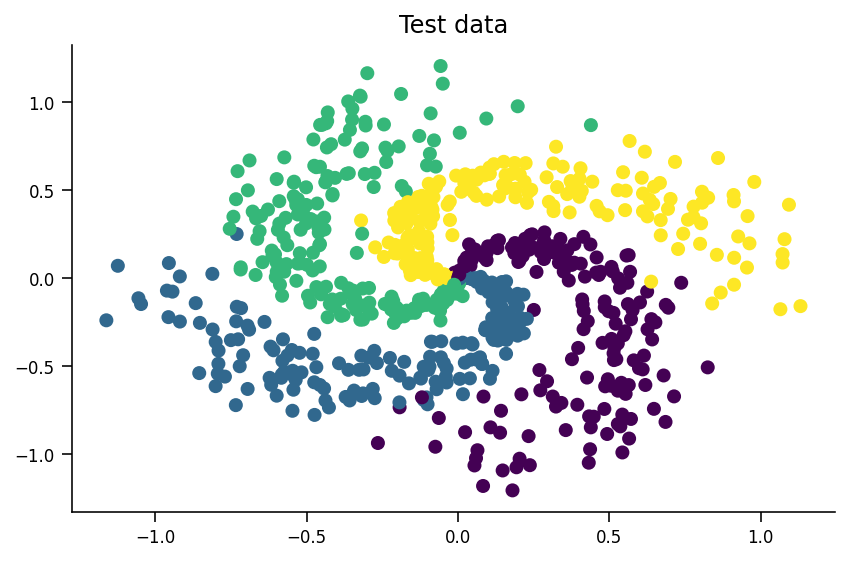

In [18]:
def shuffle_and_split_data(X, y, seed):
  """
  Helper function to shuffle and split incoming data

  Args:
    X: torch.tensor
      Input data
    y: torch.tensor
      Corresponding target variables
    seed: int
      Set seed for reproducibility

  Returns:
    X_test: torch.tensor
      Test data [20% of X]
    y_test: torch.tensor
      Labels corresponding to above mentioned test data
    X_train: torch.tensor
      Train data [80% of X]
    y_train: torch.tensor
      Labels corresponding to above mentioned train data
  """
  torch.manual_seed(seed)
  # Number of samples
  N = X.shape[0]
  ####################################################################
  # Fill in missing code below (...),
  # then remove or comment the line below to test your function
  ####################################################################
  # Shuffle data
  shuffled_indices = torch.randperm(N)   # Get indices to shuffle data, could use torch.randperm
  X = X[shuffled_indices]
  y = y[shuffled_indices]

  # Split data into train/test
  test_size = round(0.2 * N)    # Assign test datset size using 20% of samples
  X_test = X[:test_size]
  y_test = y[:test_size]
  X_train = X[test_size:]
  y_train = y[test_size:]

  return X_test, y_test, X_train, y_train

# Add event to airtable
atform.add_event('Coding Exercise 2.3: Implement for a classification task')


## Uncomment below to test your function
X_test, y_test, X_train, y_train = shuffle_and_split_data(X, y, seed=SEED)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.title('Test data')
plt.show()

And we need to make a Pytorch data loader out of it. Data loading in PyTorch can be separated in 2 parts:
* Data must be wrapped on a Dataset parent class where the methods __getitem__ and __len__ must be overrided. Note that, at this point, the data is not loaded on memory. PyTorch will only load what is needed to the memory. Here `TensorDataset` does this for us directly.
* Use a Dataloader that will actually read the data in batches and put into memory. Also, the option of `num_workers > 0` allows multithreading, which prepares multiple batches in the queue to speed things up.

In [19]:
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

batch_size = 128
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=False, num_workers=2,
                         worker_init_fn=seed_worker,
                         generator=g_seed)

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, drop_last=True,
                          shuffle=True, num_workers=2,
                          worker_init_fn=seed_worker,
                          generator=g_seed)

Let's write a general-purpose training and evaluation code and keep it in our pocket for next tutorial as well. So make sure you review it to see what it does.

Note that `model.train()` tells your model that you are training the model. So layers like dropout, batch norm etc. which behave different on the train and test procedures know what is going on and hence can behave accordingly. And to turn off training mode we set `model.eval()`.

In [20]:
def train_test_classification(net, criterion, optimizer, train_loader,
                              test_loader, num_epochs=1, verbose=True,
                              training_plot=False, device='cpu'):
  """
  Accumulate training loss/Evaluate performance

  Args:
    net: instance of Net class
      Describes the model with ReLU activation, batch size 128
    criterion: torch.nn type
      Criterion combines LogSoftmax and NLLLoss in one single class.
    optimizer: torch.optim type
      Implements Adam algorithm.
    train_loader: torch.utils.data type
      Combines the train dataset and sampler, and provides an iterable over the given dataset.
    test_loader: torch.utils.data type
      Combines the test dataset and sampler, and provides an iterable over the given dataset.
    num_epochs: int
      Number of epochs [default: 1]
    verbose: boolean
      If True, print statistics
    training_plot=False
      If True, display training plot
    device: string
      CUDA/GPU if available, CPU otherwise

  Returns:
    Nothing
  """
  net.train()
  training_losses = []
  for epoch in tqdm(range(num_epochs)):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
      # Get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs = inputs.to(device).float()
      labels = labels.to(device).long()

      # Zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # Print statistics
      if verbose:
        training_losses += [loss.item()]

  net.eval()

  def test(data_loader):
    """
    Function to gauge network performance

    Args:
      data_loader: torch.utils.data type
      Combines the test dataset and sampler, and provides an iterable over the given dataset.

    Returns:
      acc: float
        Performance of the network
      total: int
        Number of datapoints in the dataloader
    """
    correct = 0
    total = 0
    for data in data_loader:
      inputs, labels = data
      inputs = inputs.to(device).float()
      labels = labels.to(device).long()

      outputs = net(inputs)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return total, acc

  train_total, train_acc = test(train_loader)
  test_total, test_acc = test(test_loader)

  if verbose:
    print(f"Accuracy on the {train_total} training samples: {train_acc:0.2f}")
    print(f"Accuracy on the {test_total} testing samples: {test_acc:0.2f}")

  if training_plot:
    plt.plot(training_losses)
    plt.xlabel('Batch')
    plt.ylabel('Training loss')
    plt.show()

  return train_acc, test_acc

### Think! 2.3.1: What's the point of `.eval()` and `.train()`?

Is it necessary to use `net.train()` and `net.eval()` for our MLP model? why?

In [21]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q1', text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

Textarea(value='Type your answer here and click on `Submit!`', placeholder='Type something')

Button(description='Submit!', style=ButtonStyle())

Now let's put everything together and train your first deep-ish model!

Random seed 2021 has been set.


  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on the 3200 training samples: 98.16
Accuracy on the 800 testing samples: 96.88


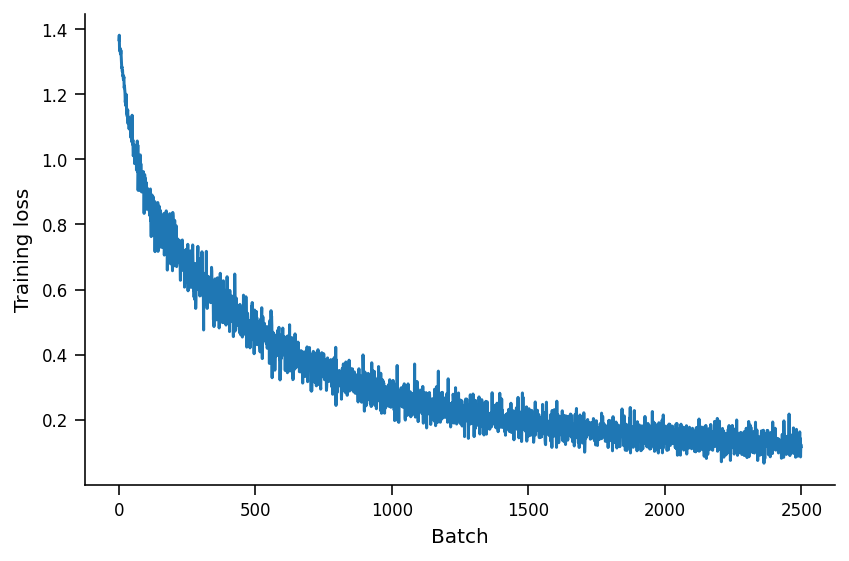

In [22]:
set_seed(SEED)
net = Net('ReLU()', X_train.shape[1], [128], K).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 100

_, _ = train_test_classification(net, criterion, optimizer, train_loader,
                                 test_loader, num_epochs=num_epochs,
                                 training_plot=True, device=DEVICE)

And finally, let's visualize the learned decision-map. We know you're probably running out of time, so we won't make you write code now! But make sure you have reviewed it since we'll start with another visualization technique next time.

In [23]:
def sample_grid(M=500, x_max=2.0):
  """
  Helper function to simulate sample meshgrid

  Args:
    M: int
      Size of the constructed tensor with meshgrid
    x_max: float
      Defines range for the set of points

  Returns:
    X_all: torch.tensor
      Concatenated meshgrid tensor
  """
  ii, jj = torch.meshgrid(torch.linspace(-x_max, x_max, M),
                          torch.linspace(-x_max, x_max, M))
  X_all = torch.cat([ii.unsqueeze(-1),
                     jj.unsqueeze(-1)],
                     dim=-1).view(-1, 2)
  return X_all


def plot_decision_map(X_all, y_pred, X_test, y_test,
                      M=500, x_max=2.0, eps=1e-3):
  """
  Helper function to plot decision map

  Args:
    X_all: torch.tensor
      Concatenated meshgrid tensor
    y_pred: torch.tensor
      Labels predicted by the network
    X_test: torch.tensor
      Test data
    y_test: torch.tensor
      Labels of the test data
    M: int
      Size of the constructed tensor with meshgrid
    x_max: float
      Defines range for the set of points
    eps: float
      Decision threshold

  Returns:
    Nothing
  """
  decision_map = torch.argmax(y_pred, dim=1)

  for i in range(len(X_test)):
    indices = (X_all[:, 0] - X_test[i, 0])**2 + (X_all[:, 1] - X_test[i, 1])**2 < eps
    decision_map[indices] = (K + y_test[i]).long()

  decision_map = decision_map.view(M, M)
  plt.imshow(decision_map, extent=[-x_max, x_max, -x_max, x_max], cmap='jet')
  plt.show()

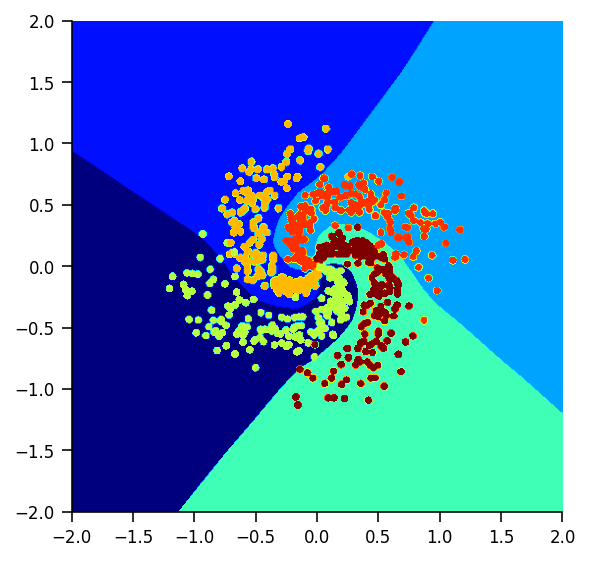

In [26]:
X_all = sample_grid()
y_pred = net(X_all.to(DEVICE))
plot_decision_map(X_all.to('cpu'), y_pred.to('cpu'), X_test.to('cpu'), y_test.to('cpu'))

### Think! 2.3.2: Does it generalize well?
Do you think this model is performing well outside its training distribution? Why?

In [27]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q2' , text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

Textarea(value='Type your answer here and click on `Submit!`', placeholder='Type something')

Button(description='Submit!', style=ButtonStyle())

In [ ]:
# to_remove explanation

"""
Not so much, since the true model is a spiral,
we'd expect that the model continues to have circular decision boundaries
as we go beyond the train distribution; And the test data may not necessarily
concur to those boundaries.
""";

What would be your suggestions to increase models ability to generalize? Think about it and discuss with your pod.

In [ ]:
# to_remove explanation

"""
Out of distribution and out of domain generalisation is very much an open research problem.
At the heart of the generalisation debate is - How can we
build better representations?

A few pointers for discussion are as follows:
1. Transforming data to include various perturbations/variations

2. Regularisation:
Generalization describes models' performance at predicting
new instances and ideally, the model should
generalize the relationship as during the training phase.
On the other hand, regularization is the process that
enhances the generalization capabilities of the model.
""";

---
# Summary

In this tutorial, we have explored the Multi-leayer Perceptrons (MLPs). More specifically, we have discussed the similarities between artificial and biological neural networks (for more information see the Bonus section). we have also learned the Universal Approximation Theorem and implemented MLPs in PyTorch.

In [ ]:
# @title Airtable Submission Link
from IPython import display as IPydisplay
IPydisplay.HTML(
   f"""
 <div>
   <a href= "{atform.url()}" target="_blank">
   <img src="https://github.com/NeuromatchAcademy/course-content-dl/blob/main/tutorials/static/AirtableSubmissionButton.png?raw=1"
 alt="button link to Airtable" style="width:410px"></a>
   </div>""" )

---
# Bonus: Neuron Physiology and Motivation to Deep Learning

This section will motivate one of the most popular nonlinearities in deep learning, the ReLU nonlinearity, by starting from the biophysics of neurons and obtaining the ReLU nonlinearity through a sequence of approximations. We will also show that neuronal biophysics sets a time scale for signal propagation speed through the brain. This time scale implies that neural circuits underlying fast perceptual and motor processing in the brain may not be excessively deep.

In [ ]:
# @title Video 5: Biological to Artificial Neurons
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1mf4y157vf", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"ELAbflymSLo", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 5: Biological to Artificial Neurons')

display(out)

## Leaky Integrate-and-fire (LIF) neuronal model

The basic idea of LIF neuron was proposed in 1907 by Louis Édouard Lapicque, long before we understood the electrophysiology of a neuron (see a translation of [Lapicque's paper](https://pubmed.ncbi.nlm.nih.gov/17968583/) ). More details of the model can be found in the book [**Theoretical neuroscience**](http://www.gatsby.ucl.ac.uk/~dayan/book/) by Peter Dayan and Laurence F. Abbott.

The model dynamics is defined with the following formula,

\begin{equation}
\frac{d V_m}{d t}=\left\{\begin{array}{cc}
\frac{1}{C_m}\left(-\frac{V_m}{R_m} + I \right) & t>t_{rest} \\
0 & \text { otherwise }
\end{array}\right.
\end{equation}


Note that $V_{m}$, $C_{m}$, and $R_{m}$ are the membrane voltage, capacitance, and resitance of the neuron, respectively, so the $-\frac{V_{m}}{R_{m}}$ denotes the leakage current. When $I$ is sufficiently strong such that $V_{m}$ reaches a certain threshold value $V_{\rm th}$, it momentarily spikes and then $V_{m}$ is reset to $V_{\rm reset}< V_{\rm th}$, and voltage stays at $V_{\rm reset}$ for $\tau_{\rm ref}$ ms, mimicking the refractoriness of the neuron during an action potential (note that $V_{\rm reset}$ and $\tau_{\rm ref}$ is assumed to be zero in the lecture):


\begin{eqnarray}
V_{m}(t)=V_{\rm reset} \text{ for } t\in(t_{\text{sp}}, t_{\text{sp}} + \tau_{\text{ref}}]
\end{eqnarray}


where $t_{\rm sp}$ is the spike time when $V_{m}(t)$ just exceeded $V_{\rm th}$.

Thus, the LIF model captures the fact that a neuron:
- Performs spatial and temporal integration of synaptic inputs 
- Generates a spike when the voltage reaches a certain threshold
- Goes refractory during the action potential
- Has a leaky membrane 

For in-depth content on computational models of neurons, follow the [NMA](https://www.neuromatchacademy.org/) tutorial 1 of *Biological Neuron Models*. Specifically, for NMA-CN 2021 follow this [Tutorial](https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/W2D3_BiologicalNeuronModels/W2D3_Tutorial1.ipynb).

## Simulating an LIF Neuron

In the cell below is given a function for LIF neuron model with it's arguments described.

Note that we will use Euler's method to make a numerical approximation to a derivative. Hence we will use the following implementation of the model dynamics,

\begin{equation}
V_m^{[n]}=\left\{\begin{array}{cc}
V_m^{[n-1]} + \frac{1}{C_m}\left(-\frac{V_m^{[n-1]}}{R_m}+I \right) \Delta t & t>t_{r e s t} \\
0 & \text { otherwise }
\end{array}\right.
\end{equation}

where the superscript $[\cdot]$ denotes the time point.

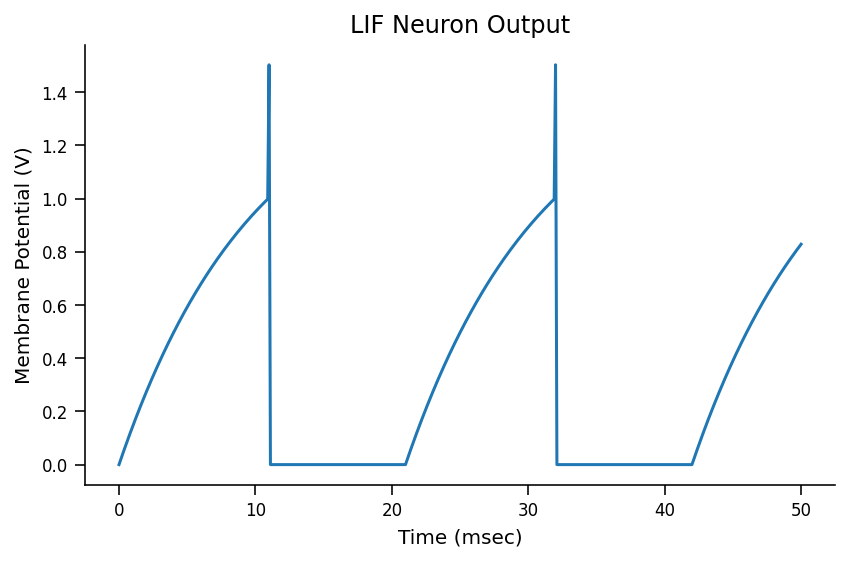

In [28]:
def run_LIF(I, T=50, dt=0.1, tau_ref=10,
            Rm=1, Cm=10, Vth=1, V_spike=0.5):
  """
  Simulate the LIF dynamics with external input current

  Args:
    I          : int
      Input current (mA)
    T          : int
      Total time to simulate (msec)
    dt         : float
      Simulation of time step (msec)
    tau_ref    : int
      Refractory period (msec)
    Rm         : int
      Resistance (kOhm)
    Cm         : int
      Capacitance (uF)
    Vth        : int
      Spike threshold (V)
    V_spike    : float
      Spike delta (V)

  Returns:
    time       : list
      Time points
    Vm         : list
      Tracking membrane potentials
  """

  # Set up array of time steps
  time = torch.arange(0, T + dt, dt)

  # Set up array for tracking Vm
  Vm = torch.zeros(len(time))

  # Iterate over each time step
  t_rest = 0
  for i, t in enumerate(time):

    # If t is after refractory period
    if t > t_rest:
      Vm[i] = Vm[i-1] + 1/Cm*(-Vm[i-1]/Rm + I)  * dt

    # If Vm is over the threshold
    if Vm[i] >= Vth:

      # Increase volatage by change due to spike
      Vm[i] += V_spike

      # Set up new refactory period
      t_rest = t + tau_ref

  return time, Vm


sim_time, Vm = run_LIF(1.5)
# Plot the membrane voltage across time
plt.plot(sim_time, Vm)
plt.title('LIF Neuron Output')
plt.ylabel('Membrane Potential (V)')
plt.xlabel('Time (msec)')
plt.show()

### Interactive Demo: Neuron's transfer function explorer for different $R_m$ and $\tau_{ref}$
We know that real neurons communicate by modulating the spike count meaning that more input current causes a neuron to spike more often. Therefore, to find an input-output relationship, it makes sense to characterize their spike count as a function of input current. This is called the neuron's input-output transfer function. Let's plot the neuron's transfer function and see how it changes with respect to the **membrane resistance** and **refractory time**? 

In [29]:
# @title

# @markdown Make sure you execute this cell to enable the widget!
my_layout = widgets.Layout()

@widgets.interact(Rm=widgets.FloatSlider(1., min=1, max=100.,
                                         step=0.1, layout=my_layout),
                  tau_ref=widgets.FloatSlider(1., min=1, max=100.,
                                            step=0.1, layout=my_layout)
                  )


def plot_IF_curve(Rm, tau_ref):
  """
  Helper function to plot frequency-current curve

  Args:
    Rm         : int
      Resistance (kOhm)
    tau_ref    : int
      Refractory period (msec)

  Returns:
    Nothing
  """
  T = 1000  # Total time to simulate (msec)
  dt = 1  # Simulation time step (msec)
  Vth = 1  # Spike threshold (V)
  Is_max = 2
  Is = torch.linspace(0, Is_max, 10)
  spike_counts = []
  for I in Is:
    _, Vm = run_LIF(I, T=T, dt=dt, Vth=Vth, Rm=Rm, tau_ref=tau_ref)
    spike_counts += [torch.sum(Vm > Vth)]

  plt.plot(Is, spike_counts)
  plt.title('LIF Neuron: Transfer Function')
  plt.ylabel('Spike count')
  plt.xlabel('I (mA)')
  plt.xlim(0, Is_max)
  plt.ylim(0, 80)
  plt.show()

interactive(children=(FloatSlider(value=1.0, description='Rm', min=1.0), FloatSlider(value=1.0, description='t…

### Think!: Real and Artificial neuron similarities

What happens at infinite membrane resistance ($R_m$) and small refactory time ($\tau_{ref}$)? Why?

Take 10 mins to discuss the similarity between a real neuron and an artificial one with your pod.

In [ ]:
# to_remove explanation

"""
At infinite membrane resistance, the neuron does not leak any current out,
and hence it starts firing with the slightest input current.
This shifts the transfer function towards 0, similar to ReLU activation (centered at 0).
Also, when there is minimal refractory time, the neuron can keep firing
at a high input current which avoids the saturation.
""";